<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>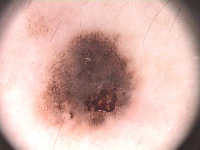</td><td>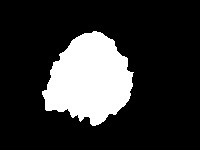</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=e50d019e-fcd6-42d4-a03f-c45e59231eb4
To: /content/PH2Dataset.rar
100% 162M/162M [00:01<00:00, 137MB/s]


In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os

root = "PH2Dataset"

for root, dirs, files in os.walk(os.path.join(root, "PH2 Dataset images")):
    if root.endswith("_Dermoscopic_Image"):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith("_lesion"):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize

size = (256, 256)
X = [
    resize(
        x,
        size,
        mode="constant",
        anti_aliasing=True,
    )
    for x in images
]
Y = [resize(y, size, mode="constant", anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np

X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f"Loaded {len(X)} images")

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

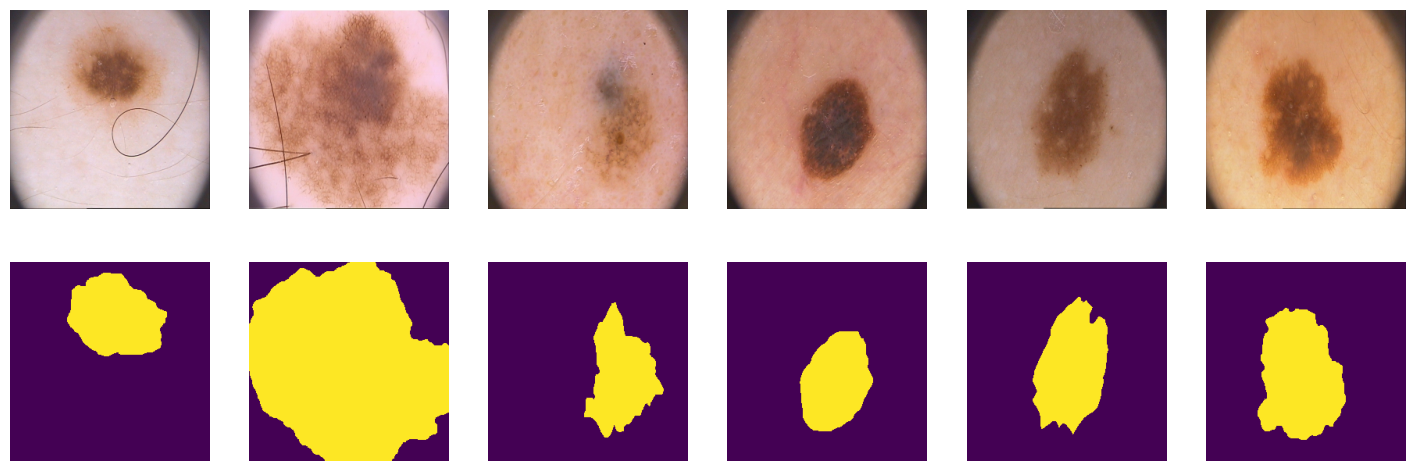

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i + 7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show()

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [7]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [8]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [9]:
from torch.utils.data import DataLoader

batch_size = 25
train_dataloader = DataLoader(
    list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
    batch_size=batch_size,
    shuffle=True,
)
valid_dataloader = DataLoader(
    list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
    batch_size=batch_size,
    shuffle=True,
)
test_dataloader = DataLoader(
    list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
    batch_size=batch_size,
    shuffle=True,
)

In [10]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [11]:
!pip install torchmetrics

In [12]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average="none").to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:** L =-(y^\*log(1/1+exp(-y^)) + (1-y)\*log(exp(-y^)/1+exp(y^))) = -(-y\*log(1+exp(-y^)) -y^ + yy^ - (1-y)\*log(1+exp(-y^))) = y^ - y\*y^ + log(1+exp(-y^))

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [13]:
import torch.nn.functional as F
import torch.nn as nn
import numpy as np

In [14]:
bce_torch = nn.BCELoss(reduction="sum")  # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction="sum")

In [15]:
def bce_loss(y_pred, y_real):
  loss =-1 * sum(
        [
            y_real[i] * torch.log(F.sigmoid(y_pred[i]))
            + (1 - y_real[i]) * torch.log(1 - F.sigmoid(y_pred[i]))
            for i in range(len(y_real))
        ]
    )
  return loss.sum()


def bce_true(y_pred, y_real):
  loss = y_pred-y_real*y_pred + torch.log(1+torch.exp(-y_pred))
  return loss.sum()

Проверим корректность работы на простом примере

In [16]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f"BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}")
print(f"BCE loss честно посчитанный = {bce_true(y_pred, y_true)}")
print(f"BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}")
print(
    f"BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}"
)

BCE loss from scratch bce_loss = 4.207910537719727
BCE loss честно посчитанный = 4.207910537719727
BCE loss from torch bce_torch = 4.207910537719727
BCE loss from torch with logits bce_torch = 4.207910537719727


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [17]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [18]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f"BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}")
print(f"BCE loss честно посчитанный = {bce_true(y_pred, y_true)}")
print(
    f"BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}"
)
print(
    f"BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}"
)

BCE loss from scratch bce_loss = 14.794151306152344
BCE loss честно посчитанный = 14.79415225982666
BCE loss from torch bce_torch = 14.79415225982666
BCE loss from torch with logits bce_torch = 14.79415225982666


In [19]:
assert np.isclose(
    bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))
)
assert np.isclose(
    bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float))
)
assert np.isclose(
    bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))
)
assert np.isclose(
    bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float))
)

Давайте посчитаем на реальных логитах и сегментационной маске:

In [20]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 4.98MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 5.15MB/s]
Download completed


In [21]:
path_to_dummy_samples = "/content/for_asserts"
dummpy_sample = {
    "logits": torch.load(f"{path_to_dummy_samples}/logits.pt"),
    "labels": torch.load(f"{path_to_dummy_samples}/labels.pt"),
}
dummpy_sample["labels"] = dummpy_sample["labels"].to(device)
dummpy_sample["logits"] = dummpy_sample["logits"].to(device)

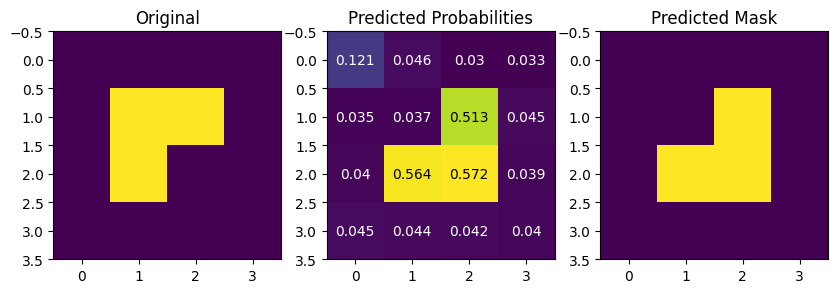

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3 * 10))

ax1.imshow(dummpy_sample["labels"].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample["logits"].sigmoid().squeeze(1)[0].cpu())
for (j, i), label in np.ndenumerate(
    dummpy_sample["logits"].sigmoid().squeeze(1)[0].cpu()
):
    if label < 0.5:
        color = "white"
    else:
        color = "black"
    ax2.text(i, j, round(label, 3), color=color, ha="center", va="center")

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample["logits"].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [23]:
bce_loss_score = bce_loss(dummpy_sample["logits"].cpu(), dummpy_sample["labels"].cpu())
bce_true_score = bce_true(dummpy_sample["logits"].cpu(), dummpy_sample["labels"].cpu())
bce_torch_score = bce_torch(
    torch.sigmoid(dummpy_sample["logits"].cpu()), dummpy_sample["labels"].cpu().float()
)
bce_torch_with_logits_score = bce_torch_with_logits(
    dummpy_sample["logits"].cpu(), dummpy_sample["labels"].cpu().float()
)
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

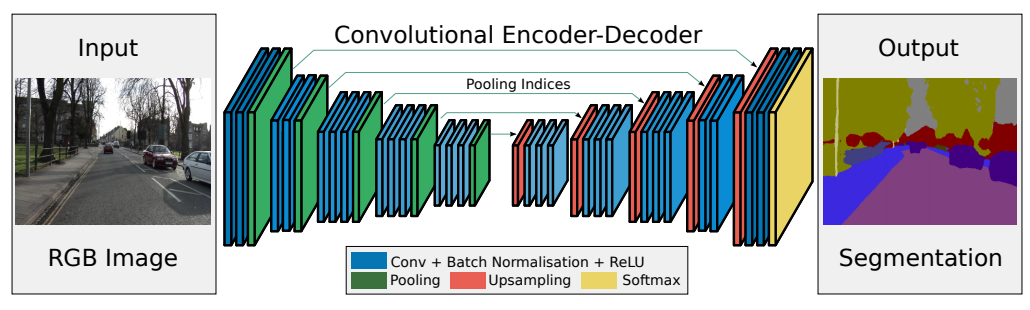

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams

rcParams["figure.figsize"] = (15, 4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [25]:
class ConvBlock(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size=3,padding=1):
    super(ConvBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=kernel_size,padding=padding)
    self.norm = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    return self.relu(self.norm(self.conv(x)))


class EncoderBlock(nn.Module):
  def __init__(self,in_channels,out_channels, depth, kernel_size,padding):
    super(EncoderBlock,self).__init__()
    self.layers = nn.ModuleList()
    for i in range(depth):
      self.layers.append(ConvBlock(in_channels if i == 0 else out_channels,out_channels,kernel_size=kernel_size, padding=padding))
    self.pool = nn.MaxPool2d(2,2,return_indices=True)

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    x, ind = self.pool(x)
    return x, ind

class DecoderBlock(nn.Module):
  def __init__(self,in_channels,out_channels, depth, kernel_size,padding,last=False):
    super(DecoderBlock,self).__init__()
    self.upsample = nn.MaxUnpool2d(2,2)
    self.layers = nn.ModuleList()
    for i in range(depth):
      if i == depth-1 and last:
        self.layers.append(nn.Conv2d(in_channels,out_channels,kernel_size=kernel_size, padding=padding))
      elif i ==depth-1:
        self.layers.append(ConvBlock(in_channels,out_channels,kernel_size=kernel_size, padding=padding))
      else:
        self.layers.append(ConvBlock(in_channels,in_channels,kernel_size=kernel_size, padding=padding))

  def forward(self, x, ind):
    x = self.upsample(x,ind)
    for layer in self.layers:
      x = layer(x)
    return x

class SegNet(nn.Module):
  def __init__(self, in_channels=3, out_channels=1,features=64):
    super(SegNet, self).__init__()

    # VGG-16 architecture
    self.encblock1 = EncoderBlock(in_channels, features, depth=2,kernel_size=3,padding=1)
    self.encblock2 = EncoderBlock(features, features*2, depth=2,kernel_size=3,padding=1)
    self.encblock3 = EncoderBlock(features*2, features*4, depth=3,kernel_size=3,padding=1)
    self.encblock4 = EncoderBlock(features*4, features*8, depth=3,kernel_size=3,padding=1)

    # bottleneck
    self.encblock5 = EncoderBlock(features*8, features*8, depth=3,kernel_size=3,padding=1)
    self.decblock1 = DecoderBlock(features*8, features*8, depth=3,kernel_size=3,padding=1,last=False)

    # decoder (upsampling)
    self.decblock2 = DecoderBlock(features*8, features*4, depth=3,kernel_size=3,padding=1,last=False)
    self.decblock3 = DecoderBlock(features*4, features*2, depth=3,kernel_size=3,padding=1,last=False)
    self.decblock4 = DecoderBlock(features*2, features, depth=2,kernel_size=3,padding=1,last=False)
    self.decblock5 = DecoderBlock(features, out_channels, depth=2,kernel_size=3,padding=1,last=True)

    # self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    # encoder
    enc1,ind1 = self.encblock1(x)
    enc2,ind2 = self.encblock2(enc1)
    enc3,ind3 = self.encblock3(enc2)
    enc4,ind4 = self.encblock4(enc3)

    # bottleneck
    enc5,ind5 = self.encblock5(enc4)
    dec1 = self.decblock1(enc5,ind5)

    # decoder
    dec2 = self.decblock2(dec1,ind4)
    dec3 = self.decblock3(dec2,ind3)
    dec4 = self.decblock4(dec3,ind2)

    output = self.decblock5(dec4,ind1)
    return output  # no activation

In [26]:
segnet_model = SegNet().to(device)

## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [27]:
from tqdm.notebook import tqdm
from datetime import datetime

In [28]:
def train(model, optimizer, loss_func, train_dataloader, valid_dataloader, epochs,device):
  train_logs = {'loss': [], 'iou': []}
  val_logs = {'loss': [], 'iou': []}

  timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
  best_epoch = 0
  # best_iou=0.7
  best_iou=0.0
  for epoch in tqdm(range(epochs),desc='Epoch'):
    model.train()
    train_iou = 0.0
    running_loss = 0.0
    for i,data in tqdm(enumerate(train_dataloader), total=len(train_dataloader),desc='Training'):
      x_batch, y_batch = data
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      y_pred = model(x_batch)

      loss = loss_func(y_pred, y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      train_iou += iou_score(y_pred,y_batch).item()

      avg_train_loss = running_loss / len(train_dataloader)
      avg_train_iou = train_iou / len(train_dataloader)

    train_logs['loss'].append(avg_train_loss)
    train_logs['iou'].append(avg_train_iou)

    print(f'Epoch {epoch+1} IoU: {avg_train_iou:.4f} Loss: {avg_train_loss:.4f}')

    model.eval()
    val_iou = 0.0
    val_loss = 0.0

    with torch.no_grad():
        for x_test, y_test in valid_dataloader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            test_pred = model(x_test)
            loss = loss_func(test_pred, y_test)

            val_loss += loss.item()
            val_iou += iou_score(test_pred, y_test).item()

    avg_val_loss = val_loss / len(valid_dataloader)
    avg_val_iou = val_iou / len(valid_dataloader)

    val_logs['loss'].append(avg_val_loss)
    val_logs['iou'].append(avg_val_iou)

    if avg_val_iou > best_iou:
      best_iou = avg_val_iou
      model_path = 'model_best.pt'.format(timestamp, epoch)
      torch.save(model.state_dict(),model_path)
      best_epoch = epoch+1
    print(f'Validation - Val IoU: {avg_val_iou:.4f}, Val Loss: {avg_val_loss:.4f}')
  print(f'Best checkpoint on epoch: {best_epoch} with IoU {best_iou:.4f}')
  return train_logs, val_logs


Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [29]:
from torch.optim import Adam

optimizer = Adam(segnet_model.parameters(), lr=0.001)
loss_func = nn.BCEWithLogitsLoss(reduction="mean")
bce_train, bce_val = train(segnet_model, optimizer,loss_func,train_dataloader,valid_dataloader, 30,device)

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1 IoU: 0.1650 Loss: 0.7312
Validation - Val IoU: 0.3007, Val Loss: 1.5142


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2 IoU: 0.0279 Loss: 0.6810
Validation - Val IoU: 0.0000, Val Loss: 0.6861


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3 IoU: 0.1112 Loss: 0.6376
Validation - Val IoU: 0.0000, Val Loss: 0.6736


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4 IoU: 0.1817 Loss: 0.5966
Validation - Val IoU: 0.0878, Val Loss: 0.6413


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5 IoU: 0.2937 Loss: 0.5493
Validation - Val IoU: 0.3636, Val Loss: 22.3386


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6 IoU: 0.4913 Loss: 0.4359
Validation - Val IoU: 0.3641, Val Loss: 24.2605


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7 IoU: 0.5922 Loss: 0.3723
Validation - Val IoU: 0.5121, Val Loss: 2.5962


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8 IoU: 0.6201 Loss: 0.3290
Validation - Val IoU: 0.5635, Val Loss: 0.5419


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9 IoU: 0.6573 Loss: 0.2861
Validation - Val IoU: 0.6099, Val Loss: 0.4354


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10 IoU: 0.7260 Loss: 0.2380
Validation - Val IoU: 0.3737, Val Loss: 0.5685


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11 IoU: 0.6782 Loss: 0.2851
Validation - Val IoU: 0.5516, Val Loss: 0.4082


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12 IoU: 0.7230 Loss: 0.2582
Validation - Val IoU: 0.6987, Val Loss: 0.2958


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13 IoU: 0.7097 Loss: 0.2659
Validation - Val IoU: 0.7450, Val Loss: 0.2811


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14 IoU: 0.7448 Loss: 0.2353
Validation - Val IoU: 0.7437, Val Loss: 0.2739


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15 IoU: 0.7137 Loss: 0.2362
Validation - Val IoU: 0.7249, Val Loss: 0.2918


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16 IoU: 0.7418 Loss: 0.2271
Validation - Val IoU: 0.7851, Val Loss: 0.2819


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17 IoU: 0.7397 Loss: 0.2241
Validation - Val IoU: 0.7550, Val Loss: 0.2463


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18 IoU: 0.7284 Loss: 0.2289
Validation - Val IoU: 0.8018, Val Loss: 0.2059


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19 IoU: 0.7571 Loss: 0.2047
Validation - Val IoU: 0.7851, Val Loss: 0.2139


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20 IoU: 0.7607 Loss: 0.2065
Validation - Val IoU: 0.7634, Val Loss: 0.3171


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21 IoU: 0.7476 Loss: 0.2036
Validation - Val IoU: 0.7862, Val Loss: 0.2129


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22 IoU: 0.7612 Loss: 0.2103
Validation - Val IoU: 0.7918, Val Loss: 0.2109


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23 IoU: 0.7359 Loss: 0.2242
Validation - Val IoU: 0.7831, Val Loss: 0.2087


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24 IoU: 0.7460 Loss: 0.2077
Validation - Val IoU: 0.8045, Val Loss: 0.1888


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25 IoU: 0.7716 Loss: 0.1926
Validation - Val IoU: 0.8030, Val Loss: 0.1975


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26 IoU: 0.7723 Loss: 0.1963
Validation - Val IoU: 0.7727, Val Loss: 0.2150


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27 IoU: 0.7399 Loss: 0.2173
Validation - Val IoU: 0.8072, Val Loss: 0.1864


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28 IoU: 0.7577 Loss: 0.2083
Validation - Val IoU: 0.7529, Val Loss: 0.2492


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29 IoU: 0.7728 Loss: 0.1931
Validation - Val IoU: 0.6561, Val Loss: 0.4239


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30 IoU: 0.7728 Loss: 0.1914
Validation - Val IoU: 0.7266, Val Loss: 0.3004
Best checkpoint on epoch: 27 with IoU 0.8072


## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [30]:
def test(model,test_dataloader,loss_func):
  model.eval()
  test_loss = 0.0
  test_iou = 0.0
  with torch.no_grad():
    for x_test, y_test in test_dataloader:
      x_test, y_test = x_test.to(device), y_test.to(device)
      test_pred = model(x_test)
      loss = loss_func(test_pred, y_test)

      test_loss += loss.item()
      test_iou += iou_score(test_pred, y_test).item()

    avg_test_loss = test_loss / len(test_dataloader)
    avg_test_iou = test_iou / len(test_dataloader)

    print(f'Test - IoU: {avg_test_iou:.4f}, Loss: {avg_test_loss:.4f}')


In [31]:
segnet_model.load_state_dict(torch.load('model_best.pt'))
test(segnet_model,test_dataloader,loss_func)

Test - IoU: 0.7462, Loss: 0.1884


# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [32]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    """
    Это именно метрика, не лосс.
    """
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()

    TP = (preds*labels).sum()
    FP = (preds*(1-labels)).sum()
    FN = ((1-preds) * labels).sum()

    EPS = 1e-8

    score = (2*TP + EPS)/(2*TP+FP+FN+EPS)

    return score

    # Soft реализация функции без порога (для DiceScore)
    # probs = torch.sigmoid(logits)
    # labels = labels.float()

    # intersection = (probs * labels).sum()
    # union = probs.sum() + labels.sum()

    # return (2 * intersection + EPS) / (union + EPS)

Проверим на корректность функцию dice_score:

In [33]:
# В DiceScore используется "soft" реализация без порога, поэтому реализация Dice Score с порогом не будет совпадать с ней по значиню
from torchmetrics.segmentation import DiceScore
dice = DiceScore(average="micro",num_classes=1).to(device)
dice(dummpy_sample["logits"].sigmoid(), dummpy_sample["labels"].to(int))

tensor(0.4244, device='cuda:0')

In [34]:
dice_score(dummpy_sample["logits"], dummpy_sample["labels"])

tensor(0.6667, device='cuda:0')

In [35]:
# Assert выдает ошибку, так как DiceScore реализован иначе

# assert dice(
#     dummpy_sample["logits"].sigmoid(), dummpy_sample["labels"].to(int)
# ) == dice_score(dummpy_sample["logits"], dummpy_sample["labels"])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [36]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):
    """
    Это лосс.
    """
    preds = torch.sigmoid(logits)

    TP = (preds*labels).sum()
    FP = (preds*(1-labels)).sum()
    FN = ((1-preds) * labels).sum()

    EPS = 1e-8

    loss = (2*TP + EPS)/(2*TP+FP+FN+EPS)

    return 1-loss

Проверка на корректность:

In [ ]:
# проверьте, что у вас установлена библиотека
#!pip install segmentation-models-pytorch

In [37]:
!pip install monai

In [38]:
# from segmentation_models_pytorch.losses import DiceLoss

from monai.losses import DiceLoss
dice_loss_torch = DiceLoss(sigmoid=True)


dice_loss_torch = DiceLoss(sigmoid=True)
dice_loss_torch(dummpy_sample["logits"], dummpy_sample["labels"])

tensor(0.5756, device='cuda:0')

In [39]:
dice_loss(dummpy_sample["logits"], dummpy_sample["labels"])

tensor(0.5756, device='cuda:0')

In [40]:
dice_torch_loss = dice_loss_torch(
    dummpy_sample["logits"], dummpy_sample["labels"].to(int)
)
dice_loss_my = dice_loss(dummpy_sample["logits"], dummpy_sample["labels"])


assert torch.allclose(dice_torch_loss, dice_loss_my,atol=1e-5)

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [41]:
def focal_loss(y_real, y_pred, eps=1e-8, gamma=2):
    probs = torch.sigmoid(y_pred)
    l_bce = -(y_real*torch.log(probs+eps) + (1-y_real)*torch.log(1-probs+eps))
    p_t = probs*y_real + (1-probs)*(1-y_real)
    loss = (1-p_t)**gamma * l_bce
    return loss.mean()

Проверка корректности функции:

In [42]:
from torchvision.ops import sigmoid_focal_loss

sigmoid_focal_loss(
    dummpy_sample["logits"], dummpy_sample["labels"], alpha=-1, gamma=2, reduction="mean"
)

tensor(0.2260, device='cuda:0')

In [43]:
focal_loss(dummpy_sample["labels"], dummpy_sample["logits"], gamma=2.0)

tensor(0.2260, device='cuda:0')

In [44]:
assert torch.allclose(
    sigmoid_focal_loss(dummpy_sample["logits"], dummpy_sample["labels"], alpha=-1
                       , gamma=2, reduction="mean"),focal_loss(dummpy_sample["labels"], dummpy_sample["logits"], gamma=2.0)
    ,atol=1e-6)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



In [45]:
def wrapped_sigmoid_focal_loss(y_pred, y_real):
    return sigmoid_focal_loss(y_pred, y_real, reduction='mean')

losses = [dice_loss, wrapped_sigmoid_focal_loss]
results = []

for loss_func in losses:
  segnet_model = SegNet().to(device)
  optimizer = Adam(segnet_model.parameters(), lr=0.001)
  print(f'Training with loss: ',{loss_func})
  train_res, val_res = train(segnet_model, optimizer,loss_func,train_dataloader,valid_dataloader, 30,device)
  results.append([train_res,val_res])

dice_train, dice_val = results[0]
focal_train, focal_val = results[1]

Training with loss:  {<function dice_loss at 0x7bde8459b1a0>}


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1 IoU: 0.3041 Loss: 0.5633
Validation - Val IoU: 0.3434, Val Loss: 0.5807


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2 IoU: 0.5396 Loss: 0.4212
Validation - Val IoU: 0.3673, Val Loss: 0.4464


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3 IoU: 0.6051 Loss: 0.3635
Validation - Val IoU: 0.4024, Val Loss: 0.4381


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4 IoU: 0.6765 Loss: 0.2977
Validation - Val IoU: 0.3084, Val Loss: 0.5157


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5 IoU: 0.7083 Loss: 0.2466
Validation - Val IoU: 0.3634, Val Loss: 0.4706


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6 IoU: 0.7114 Loss: 0.2178
Validation - Val IoU: 0.5141, Val Loss: 0.3322


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7 IoU: 0.7149 Loss: 0.1949
Validation - Val IoU: 0.6227, Val Loss: 0.2440


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8 IoU: 0.7334 Loss: 0.1796
Validation - Val IoU: 0.5991, Val Loss: 0.2580


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9 IoU: 0.7230 Loss: 0.1788
Validation - Val IoU: 0.6245, Val Loss: 0.2374


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10 IoU: 0.7536 Loss: 0.1536
Validation - Val IoU: 0.7868, Val Loss: 0.1330


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11 IoU: 0.7604 Loss: 0.1465
Validation - Val IoU: 0.8044, Val Loss: 0.1170


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12 IoU: 0.7593 Loss: 0.1461
Validation - Val IoU: 0.8045, Val Loss: 0.1159


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13 IoU: 0.7336 Loss: 0.1648
Validation - Val IoU: 0.8241, Val Loss: 0.1061


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14 IoU: 0.7646 Loss: 0.1383
Validation - Val IoU: 0.8371, Val Loss: 0.0964


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15 IoU: 0.7741 Loss: 0.1334
Validation - Val IoU: 0.8231, Val Loss: 0.1052


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16 IoU: 0.7577 Loss: 0.1421
Validation - Val IoU: 0.7899, Val Loss: 0.1220


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17 IoU: 0.7713 Loss: 0.1326
Validation - Val IoU: 0.8038, Val Loss: 0.1132


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18 IoU: 0.7736 Loss: 0.1319
Validation - Val IoU: 0.8121, Val Loss: 0.1075


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19 IoU: 0.8027 Loss: 0.1128
Validation - Val IoU: 0.7889, Val Loss: 0.1219


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20 IoU: 0.7961 Loss: 0.1168
Validation - Val IoU: 0.8140, Val Loss: 0.1058


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21 IoU: 0.7580 Loss: 0.1411
Validation - Val IoU: 0.8069, Val Loss: 0.1103


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22 IoU: 0.7564 Loss: 0.1430
Validation - Val IoU: 0.7872, Val Loss: 0.1232


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23 IoU: 0.7683 Loss: 0.1339
Validation - Val IoU: 0.8247, Val Loss: 0.0991


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24 IoU: 0.8054 Loss: 0.1108
Validation - Val IoU: 0.8460, Val Loss: 0.0867


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25 IoU: 0.7997 Loss: 0.1140
Validation - Val IoU: 0.7091, Val Loss: 0.1714


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26 IoU: 0.8198 Loss: 0.1013
Validation - Val IoU: 0.8233, Val Loss: 0.0996


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27 IoU: 0.8020 Loss: 0.1120
Validation - Val IoU: 0.8266, Val Loss: 0.0976


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28 IoU: 0.8050 Loss: 0.1109
Validation - Val IoU: 0.8199, Val Loss: 0.1023


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29 IoU: 0.7807 Loss: 0.1256
Validation - Val IoU: 0.8192, Val Loss: 0.1058


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30 IoU: 0.7840 Loss: 0.1244
Validation - Val IoU: 0.7840, Val Loss: 0.1226
Best checkpoint on epoch: 24 with IoU 0.8460
Training with loss:  {<function wrapped_sigmoid_focal_loss at 0x7bdfc797fba0>}


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1 IoU: 0.1022 Loss: 0.1009
Validation - Val IoU: 0.0000, Val Loss: 0.0945


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2 IoU: 0.0192 Loss: 0.0708
Validation - Val IoU: 0.0000, Val Loss: 0.0805


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3 IoU: 0.0036 Loss: 0.0624
Validation - Val IoU: 0.0000, Val Loss: 0.0772


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4 IoU: 0.0059 Loss: 0.0615
Validation - Val IoU: 0.0116, Val Loss: 1.1087


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5 IoU: 0.0161 Loss: 0.0556
Validation - Val IoU: 0.1030, Val Loss: 2.7815


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6 IoU: 0.0845 Loss: 0.0483
Validation - Val IoU: 0.5205, Val Loss: 0.6012


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7 IoU: 0.2863 Loss: 0.0414
Validation - Val IoU: 0.5665, Val Loss: 0.9690


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8 IoU: 0.2819 Loss: 0.0419
Validation - Val IoU: 0.5558, Val Loss: 0.6002


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9 IoU: 0.4330 Loss: 0.0350
Validation - Val IoU: 0.5974, Val Loss: 0.1656


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10 IoU: 0.6040 Loss: 0.0300
Validation - Val IoU: 0.6662, Val Loss: 0.0904


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11 IoU: 0.6173 Loss: 0.0274
Validation - Val IoU: 0.5814, Val Loss: 0.2353


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12 IoU: 0.6416 Loss: 0.0286
Validation - Val IoU: 0.6980, Val Loss: 0.0945


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13 IoU: 0.5550 Loss: 0.0307
Validation - Val IoU: 0.6943, Val Loss: 0.0284


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14 IoU: 0.6175 Loss: 0.0310
Validation - Val IoU: 0.6924, Val Loss: 0.0296


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15 IoU: 0.6825 Loss: 0.0282
Validation - Val IoU: 0.7535, Val Loss: 0.0549


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16 IoU: 0.6393 Loss: 0.0270
Validation - Val IoU: 0.7179, Val Loss: 0.1276


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17 IoU: 0.6718 Loss: 0.0292
Validation - Val IoU: 0.6966, Val Loss: 0.1451


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18 IoU: 0.6465 Loss: 0.0255
Validation - Val IoU: 0.7637, Val Loss: 0.0292


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19 IoU: 0.6914 Loss: 0.0225
Validation - Val IoU: 0.5024, Val Loss: 0.0337


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20 IoU: 0.6920 Loss: 0.0247
Validation - Val IoU: 0.6587, Val Loss: 0.0553


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21 IoU: 0.6449 Loss: 0.0226
Validation - Val IoU: 0.6884, Val Loss: 0.0243


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22 IoU: 0.6935 Loss: 0.0237
Validation - Val IoU: 0.6875, Val Loss: 0.0272


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23 IoU: 0.7225 Loss: 0.0192
Validation - Val IoU: 0.6964, Val Loss: 0.0297


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24 IoU: 0.7252 Loss: 0.0246
Validation - Val IoU: 0.6964, Val Loss: 0.0240


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25 IoU: 0.6608 Loss: 0.0214
Validation - Val IoU: 0.7229, Val Loss: 0.0209


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26 IoU: 0.6563 Loss: 0.0224
Validation - Val IoU: 0.7979, Val Loss: 0.0189


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27 IoU: 0.7051 Loss: 0.0209
Validation - Val IoU: 0.7788, Val Loss: 0.0182


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28 IoU: 0.7243 Loss: 0.0203
Validation - Val IoU: 0.7068, Val Loss: 0.0223


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29 IoU: 0.7379 Loss: 0.0199
Validation - Val IoU: 0.7813, Val Loss: 0.0200


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30 IoU: 0.7520 Loss: 0.0202
Validation - Val IoU: 0.8131, Val Loss: 0.0175
Best checkpoint on epoch: 30 with IoU 0.8131


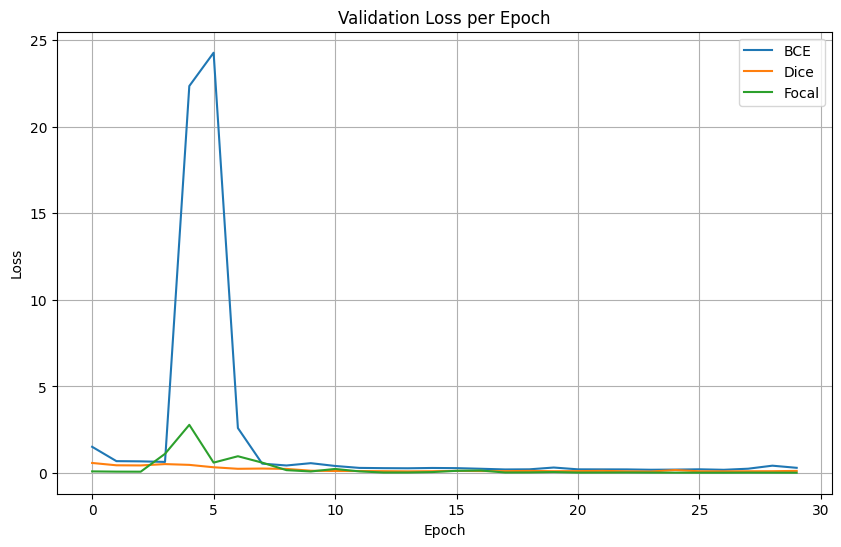

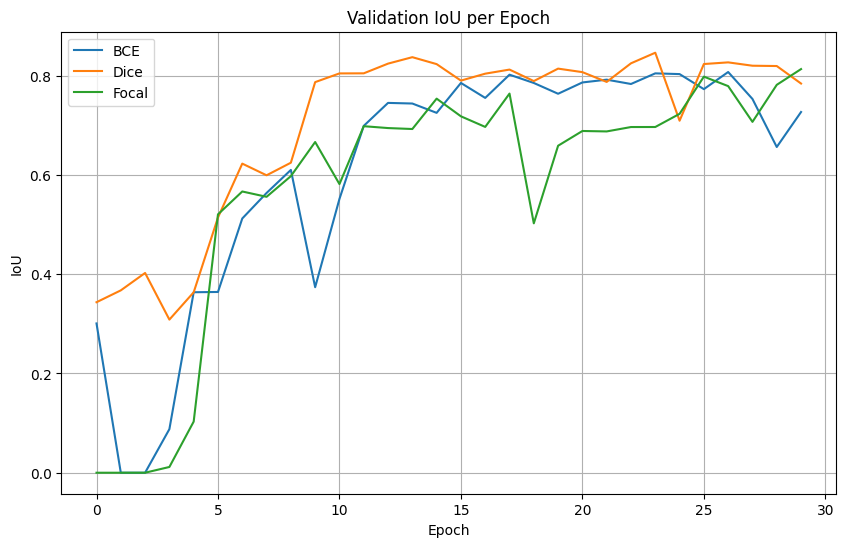

In [46]:
import matplotlib.pyplot as plt

def plot_metrics(metrics_dict, title, ylabel):
    plt.figure(figsize=(10,6))
    for name, values in metrics_dict.items():
        plt.plot(values, label=name)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

loss_curves = {
    'BCE': bce_val['loss'],
    'Dice': dice_val['loss'],
    'Focal': focal_val['loss']
}

iou_curves = {
    'BCE': bce_val['iou'],
    'Dice': dice_val['iou'],
    'Focal': focal_val['iou']
}

plot_metrics(loss_curves, 'Validation Loss per Epoch', 'Loss')
plot_metrics(iou_curves, 'Validation IoU per Epoch', 'IoU')


## Ответы на вопросы

*   При каком лоссе модель сходится быстрее?

  Модель обучается быстрее при лоссе dice, лосс BCE является менее стабильным, несмотря на то, что focal loss проходит ассерты и его имплементация выглядит правильной, он не обучает модель

*   При каком лоссе модель выдает наилучшую метрику?

  Наилучшую метрику модель выдает при лоссе Dice


# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

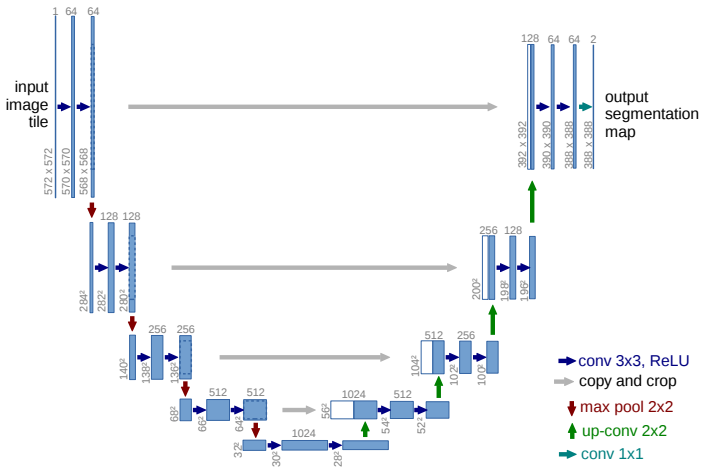

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [47]:
import torch.nn.functional as F
import torch.nn as nn
import torchvision

In [48]:
# class Block(nn.Module):
#     def __init__(self, in_ch, out_ch):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3,padding=1)
#         self.relu = nn.ReLU()
#         self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3,padding=1)

#     def forward(self, x):
#         return self.conv2(self.relu(self.conv1(x)))

class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x


class Encoder(nn.Module):
    def __init__(self, chs=(3, 64, 128, 256, 512, 1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList(
            [Block(chs[i], chs[i + 1]) for i in range(len(chs) - 1)]
        )
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs = chs
        self.upconvs = nn.ModuleList(
            [nn.ConvTranspose2d(chs[i], chs[i + 1], 2, 2) for i in range(len(chs) - 1)]
        )
        self.dec_blocks = nn.ModuleList(
            [Block(chs[i], chs[i + 1]) for i in range(len(chs) - 1)]
        )

    def forward(self, x, encoder_features):
        for i in range(len(self.chs) - 1):
            x = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x = torch.cat([x, enc_ftrs], dim=1)
            x = self.dec_blocks[i](x)
        return x

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(
        self,
        enc_chs=(3, 64, 128, 256, 512, 1024),
        dec_chs=(1024, 512, 256, 128, 64),
        num_class=1,
        retain_dim=False,
        out_sz=(572, 572),
    ):
        super().__init__()
        self.encoder = Encoder(enc_chs)
        self.decoder = Decoder(dec_chs)
        self.head = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out = self.head(out)
        # if self.retain_dim:
        #     out = F.interpolate(out, out_sz)
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)
        return out


In [49]:
unet_model = UNet().to(device)

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



In [50]:
from torch.optim import Adam

losses = [nn.BCEWithLogitsLoss(reduction="mean"), DiceLoss(sigmoid=True),wrapped_sigmoid_focal_loss]
results = []

for loss_func in losses:
  unet_model = UNet().to(device)
  optimizer = Adam(unet_model.parameters(), lr=0.001)
  print(f'Training with loss: {loss_func}')
  train_res, val_res = train(unet_model, optimizer,loss_func,train_dataloader,valid_dataloader, 30,device)
  results.append([train_res,val_res])

Training with loss: BCEWithLogitsLoss()


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1 IoU: 0.4367 Loss: 0.5423
Validation - Val IoU: 0.0000, Val Loss: 0.6751


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2 IoU: 0.6520 Loss: 0.3651
Validation - Val IoU: 0.3805, Val Loss: 3.0433


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3 IoU: 0.6781 Loss: 0.3302
Validation - Val IoU: 0.0167, Val Loss: 0.5849


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4 IoU: 0.7105 Loss: 0.3022
Validation - Val IoU: 0.1318, Val Loss: 0.6238


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5 IoU: 0.6925 Loss: 0.2983
Validation - Val IoU: 0.1656, Val Loss: 0.5148


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6 IoU: 0.6943 Loss: 0.2923
Validation - Val IoU: 0.3422, Val Loss: 0.5152


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7 IoU: 0.6236 Loss: 0.3207
Validation - Val IoU: 0.5533, Val Loss: 0.4745


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8 IoU: 0.6562 Loss: 0.2793
Validation - Val IoU: 0.6320, Val Loss: 0.3050


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9 IoU: 0.6879 Loss: 0.2748
Validation - Val IoU: 0.7084, Val Loss: 0.2767


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10 IoU: 0.7140 Loss: 0.2531
Validation - Val IoU: 0.7126, Val Loss: 0.3155


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11 IoU: 0.7212 Loss: 0.2488
Validation - Val IoU: 0.7691, Val Loss: 0.2537


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12 IoU: 0.7358 Loss: 0.2447
Validation - Val IoU: 0.8152, Val Loss: 0.1971


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13 IoU: 0.7688 Loss: 0.2242
Validation - Val IoU: 0.7944, Val Loss: 0.2166


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14 IoU: 0.7070 Loss: 0.2771
Validation - Val IoU: 0.8295, Val Loss: 0.2084


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15 IoU: 0.7298 Loss: 0.2512
Validation - Val IoU: 0.8134, Val Loss: 0.2201


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16 IoU: 0.7558 Loss: 0.2335
Validation - Val IoU: 0.6452, Val Loss: 0.4387


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17 IoU: 0.7476 Loss: 0.2240
Validation - Val IoU: 0.6202, Val Loss: 0.4310


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18 IoU: 0.7634 Loss: 0.2118
Validation - Val IoU: 0.8288, Val Loss: 0.1720


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19 IoU: 0.7711 Loss: 0.2147
Validation - Val IoU: 0.7952, Val Loss: 0.2132


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20 IoU: 0.7856 Loss: 0.1989
Validation - Val IoU: 0.8101, Val Loss: 0.2035


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21 IoU: 0.7963 Loss: 0.1985
Validation - Val IoU: 0.7830, Val Loss: 0.2550


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22 IoU: 0.7806 Loss: 0.2033
Validation - Val IoU: 0.7534, Val Loss: 0.2612


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23 IoU: 0.7618 Loss: 0.2111
Validation - Val IoU: 0.7517, Val Loss: 0.2821


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24 IoU: 0.7611 Loss: 0.2169
Validation - Val IoU: 0.7775, Val Loss: 0.2681


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25 IoU: 0.7845 Loss: 0.2004
Validation - Val IoU: 0.7809, Val Loss: 0.2312


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26 IoU: 0.7853 Loss: 0.1942
Validation - Val IoU: 0.8093, Val Loss: 0.1920


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27 IoU: 0.8029 Loss: 0.1797
Validation - Val IoU: 0.8423, Val Loss: 0.1608


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28 IoU: 0.7960 Loss: 0.1821
Validation - Val IoU: 0.8251, Val Loss: 0.1793


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29 IoU: 0.8060 Loss: 0.1760
Validation - Val IoU: 0.8218, Val Loss: 0.1817


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30 IoU: 0.7990 Loss: 0.1801
Validation - Val IoU: 0.7991, Val Loss: 0.1902
Best checkpoint on epoch: 27 with IoU 0.8423
Training with loss: DiceLoss()


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1 IoU: 0.4882 Loss: 0.5238
Validation - Val IoU: 0.1017, Val Loss: 0.6218


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2 IoU: 0.5488 Loss: 0.4215
Validation - Val IoU: 0.0960, Val Loss: 0.7858


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3 IoU: 0.6239 Loss: 0.3912
Validation - Val IoU: 0.3027, Val Loss: 0.5749


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4 IoU: 0.6329 Loss: 0.3701
Validation - Val IoU: 0.4498, Val Loss: 0.5119


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5 IoU: 0.6466 Loss: 0.3497
Validation - Val IoU: 0.5131, Val Loss: 0.4562


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6 IoU: 0.6660 Loss: 0.3254
Validation - Val IoU: 0.6843, Val Loss: 0.3408


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7 IoU: 0.6843 Loss: 0.3076
Validation - Val IoU: 0.6359, Val Loss: 0.3475


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8 IoU: 0.7073 Loss: 0.2956
Validation - Val IoU: 0.5622, Val Loss: 0.3551


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9 IoU: 0.7416 Loss: 0.2781
Validation - Val IoU: 0.7688, Val Loss: 0.2835


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10 IoU: 0.7575 Loss: 0.2625
Validation - Val IoU: 0.6927, Val Loss: 0.3140


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11 IoU: 0.7411 Loss: 0.2481
Validation - Val IoU: 0.7371, Val Loss: 0.2643


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12 IoU: 0.7738 Loss: 0.2363
Validation - Val IoU: 0.8103, Val Loss: 0.2223


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13 IoU: 0.7939 Loss: 0.2255
Validation - Val IoU: 0.8356, Val Loss: 0.1899


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14 IoU: 0.7220 Loss: 0.2314
Validation - Val IoU: 0.7801, Val Loss: 0.2057


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15 IoU: 0.7781 Loss: 0.2068
Validation - Val IoU: 0.8467, Val Loss: 0.1792


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16 IoU: 0.7629 Loss: 0.2107
Validation - Val IoU: 0.8229, Val Loss: 0.1866


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17 IoU: 0.7543 Loss: 0.2023
Validation - Val IoU: 0.8247, Val Loss: 0.1612


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18 IoU: 0.7853 Loss: 0.1847
Validation - Val IoU: 0.7725, Val Loss: 0.1840


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19 IoU: 0.7920 Loss: 0.1734
Validation - Val IoU: 0.7315, Val Loss: 0.2266


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20 IoU: 0.7989 Loss: 0.1708
Validation - Val IoU: 0.8002, Val Loss: 0.1675


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21 IoU: 0.8049 Loss: 0.1645
Validation - Val IoU: 0.7841, Val Loss: 0.1783


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22 IoU: 0.8133 Loss: 0.1558
Validation - Val IoU: 0.8393, Val Loss: 0.1295


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23 IoU: 0.8233 Loss: 0.1493
Validation - Val IoU: 0.7693, Val Loss: 0.1832


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24 IoU: 0.8372 Loss: 0.1353
Validation - Val IoU: 0.8317, Val Loss: 0.1303


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25 IoU: 0.8160 Loss: 0.1377
Validation - Val IoU: 0.8595, Val Loss: 0.1097


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26 IoU: 0.8305 Loss: 0.1293
Validation - Val IoU: 0.8537, Val Loss: 0.1110


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27 IoU: 0.8326 Loss: 0.1276
Validation - Val IoU: 0.8334, Val Loss: 0.1270


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28 IoU: 0.8409 Loss: 0.1218
Validation - Val IoU: 0.8391, Val Loss: 0.1280


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29 IoU: 0.8551 Loss: 0.1112
Validation - Val IoU: 0.8604, Val Loss: 0.1094


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30 IoU: 0.8424 Loss: 0.1153
Validation - Val IoU: 0.8510, Val Loss: 0.1090
Best checkpoint on epoch: 29 with IoU 0.8604
Training with loss: <function wrapped_sigmoid_focal_loss at 0x7bdfc797fba0>


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1 IoU: 0.3694 Loss: 0.0593
Validation - Val IoU: 0.0000, Val Loss: 0.0780


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2 IoU: 0.5114 Loss: 0.0369
Validation - Val IoU: 0.0000, Val Loss: 0.0663


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3 IoU: 0.6245 Loss: 0.0286
Validation - Val IoU: 0.0063, Val Loss: 0.0592


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4 IoU: 0.6387 Loss: 0.0274
Validation - Val IoU: 0.0183, Val Loss: 0.0515


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5 IoU: 0.6451 Loss: 0.0265
Validation - Val IoU: 0.0653, Val Loss: 0.0487


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6 IoU: 0.6540 Loss: 0.0243
Validation - Val IoU: 0.1814, Val Loss: 0.0435


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7 IoU: 0.6047 Loss: 0.0288
Validation - Val IoU: 0.3504, Val Loss: 0.0367


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8 IoU: 0.6341 Loss: 0.0249
Validation - Val IoU: 0.3978, Val Loss: 0.0352


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9 IoU: 0.6957 Loss: 0.0240
Validation - Val IoU: 0.4984, Val Loss: 0.0384


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10 IoU: 0.6824 Loss: 0.0232
Validation - Val IoU: 0.6052, Val Loss: 0.0313


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11 IoU: 0.6758 Loss: 0.0234
Validation - Val IoU: 0.6748, Val Loss: 0.0311


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12 IoU: 0.6462 Loss: 0.0275
Validation - Val IoU: 0.6307, Val Loss: 0.0413


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13 IoU: 0.6526 Loss: 0.0253
Validation - Val IoU: 0.7228, Val Loss: 0.0204


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14 IoU: 0.6602 Loss: 0.0242
Validation - Val IoU: 0.7537, Val Loss: 0.0214


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15 IoU: 0.7206 Loss: 0.0209
Validation - Val IoU: 0.8359, Val Loss: 0.0193


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16 IoU: 0.7240 Loss: 0.0230
Validation - Val IoU: 0.8073, Val Loss: 0.0326


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17 IoU: 0.7061 Loss: 0.0202
Validation - Val IoU: 0.5778, Val Loss: 0.0296


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18 IoU: 0.7463 Loss: 0.0190
Validation - Val IoU: 0.8368, Val Loss: 0.0194


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19 IoU: 0.7926 Loss: 0.0173
Validation - Val IoU: 0.8286, Val Loss: 0.0230


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20 IoU: 0.8040 Loss: 0.0169
Validation - Val IoU: 0.8420, Val Loss: 0.0145


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21 IoU: 0.7868 Loss: 0.0174
Validation - Val IoU: 0.8660, Val Loss: 0.0151


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22 IoU: 0.7778 Loss: 0.0173
Validation - Val IoU: 0.7181, Val Loss: 0.0518


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23 IoU: 0.7908 Loss: 0.0170
Validation - Val IoU: 0.8520, Val Loss: 0.0152


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24 IoU: 0.7980 Loss: 0.0164
Validation - Val IoU: 0.7661, Val Loss: 0.0219


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25 IoU: 0.8100 Loss: 0.0154
Validation - Val IoU: 0.7693, Val Loss: 0.0219


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26 IoU: 0.8032 Loss: 0.0160
Validation - Val IoU: 0.8260, Val Loss: 0.0144


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27 IoU: 0.8027 Loss: 0.0162
Validation - Val IoU: 0.8055, Val Loss: 0.0161


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28 IoU: 0.8018 Loss: 0.0168
Validation - Val IoU: 0.8312, Val Loss: 0.0153


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29 IoU: 0.8102 Loss: 0.0151
Validation - Val IoU: 0.7963, Val Loss: 0.0194


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30 IoU: 0.8047 Loss: 0.0150
Validation - Val IoU: 0.7783, Val Loss: 0.0210
Best checkpoint on epoch: 21 with IoU 0.8660


In [51]:
bce_train, bce_val = results[0]
dice_train, dice_val = results[1]
focal_train, focal_val = results[2]

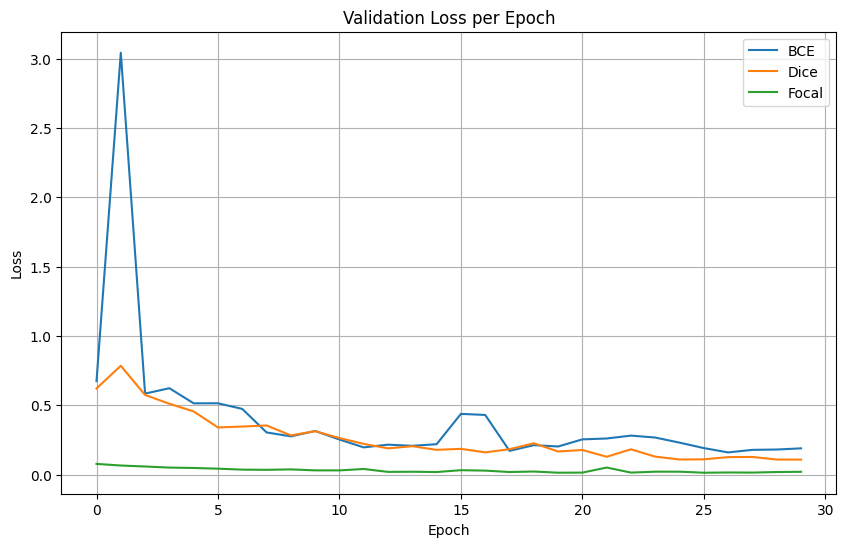

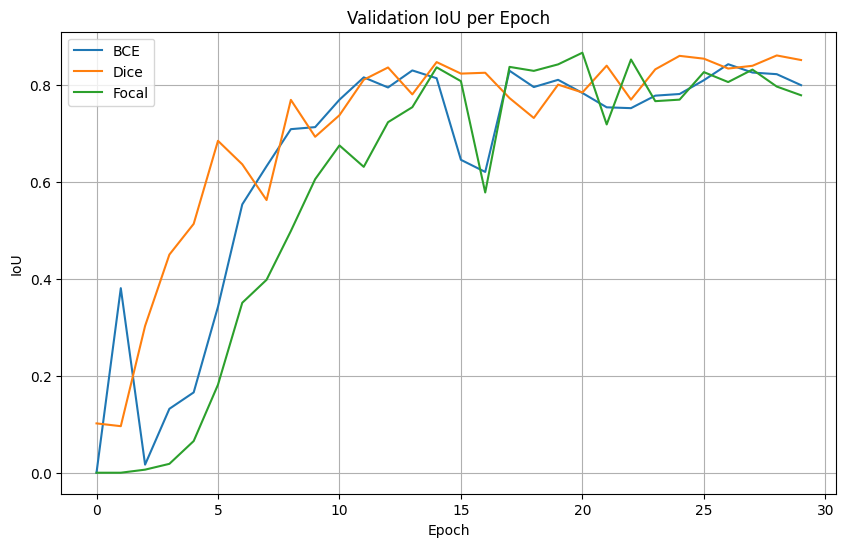

In [52]:
import matplotlib.pyplot as plt

def plot_metrics(metrics_dict, title, ylabel):
    plt.figure(figsize=(10,6))
    for name, values in metrics_dict.items():
        plt.plot(values, label=name)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

loss_curves = {
    'BCE': bce_val['loss'],
    'Dice': dice_val['loss'],
    'Focal': focal_val['loss']
}

iou_curves = {
    'BCE': bce_val['iou'],
    'Dice': dice_val['iou'],
    'Focal': focal_val['iou']
}

plot_metrics(loss_curves, 'Validation Loss per Epoch', 'Loss')
plot_metrics(iou_curves, 'Validation IoU per Epoch', 'IoU')


## Ответы на вопросы
*   Какая модель дает лучшие значения по метрике?
  
  UNET дает лучшие значения по метрике

*   Какая модель дает лучшие значения по лоссам?

  UNET дает лучшие значения по лоссам

*   Какая модель обучается быстрее?

  Модели обучаются с приблизительно одинаковой скоростью

*   Сравните визуально результаты SegNet и UNet.

  При обучении SegNet IoU менее "стабилен", UNet обучается стабильнее. IoU получилась чуть выше на Unet под конец обучения, но незначительно и обе модели выдают неплохую точность на 30 эпохе на всех лоссах.